## EDA

In [210]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('tableau-colorblind10')

### Config

In [84]:
if "chdir_done" not in globals():
    os.chdir("..")
    chdir_done = True

work_directory = os.getcwd()

### Constants

In [85]:
headers = {
    "selector": "th.col_heading",
    "props": "background-color: #7a7adf; color: white;",
}
index_style = {
    "selector": "th.index_name",
    "props": "background-color: #7a7adf; color: white;",
}

In [86]:
CLEAN_FILE = "data/clear_data.pkl"

### Импорт и проверка данных

In [87]:
df_ecom = pd.read_pickle(CLEAN_FILE)

In [88]:
df_ecom.head()

,user_id,product_id,category,price,discount,final_price,payment_method,purchase_date
0,337c166f,f414122f-e,Sports,36.53,15,31.05,Net Banking,2024-11-12
1,d38a19bf,fde50f9c-5,Clothing,232.79,20,186.23,Net Banking,2024-02-09
2,d7f5f0b0,0d96fc90-3,Sports,317.02,25,237.76,Credit Card,2024-09-01
3,395d4994,964fc44b-d,Toys,173.19,25,129.89,UPI,2024-04-01
4,a83c145c,d70e2fc6-e,Beauty,244.80,20,195.84,Net Banking,2024-09-27


In [89]:
df_ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660 entries, 0 to 3659
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3660 non-null   object        
 1   product_id      3660 non-null   object        
 2   category        3660 non-null   object        
 3   price           3660 non-null   float64       
 4   discount        3660 non-null   int64         
 5   final_price     3660 non-null   float64       
 6   payment_method  3660 non-null   object        
 7   purchase_date   3660 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 228.9+ KB


#### Проверка на пропуски

In [90]:
df_ecom.isnull().sum()

user_id           0
product_id        0
category          0
price             0
discount          0
final_price       0
payment_method    0
purchase_date     0
dtype: int64

<div class="alert alert-success">
    <strong>Итого</strong>: Пропусков нет
</div>

#### Проверка на дубликаты

In [91]:
df_ecom.duplicated().sum()

np.int64(0)

<div class="alert alert-success">
    <strong>Итого</strong>: Дубликатов нет
</div>

### Описание данных

In [92]:
df_ecom.describe()

,price,discount,final_price,purchase_date
count,3660.000000,3660.000000,3660.000000,3660
mean,254.800675,18.825137,206.906579,2024-06-13 00:46:01.967213056
min,10.090000,0.000000,5.890000,2024-01-01 00:00:00
25%,134.012500,5.000000,104.512500,2024-03-24 00:00:00
50%,253.845000,15.000000,199.185000,2024-06-11 12:00:00
75%,377.595000,25.000000,304.117500,2024-09-03 00:00:00
max,499.960000,50.000000,496.820000,2024-11-21 00:00:00
std,141.682621,14.731338,122.687844,NaN


#### Итого обработки данных

- В ценах на первый взгляд значительного отклонения не наблюдается
- Скидки также адекватные. И более 50% скидка не предоставлялась
- Данные представлены с `2024-01-01` по `2024-11-21`

---

### Категориальные данные

In [93]:
df_ecom.describe(include="all")[["category", "payment_method"]].dropna()

,category,payment_method
count,3660,3660
unique,7,5
top,Home & Kitchen,Credit Card
freq,549,760


Представлено 7 категорий и 5 методов оплаты

#### Анализ категорий

In [94]:
pd.concat(
    [
        df_ecom["category"].value_counts(),
        df_ecom["category"].value_counts() / df_ecom["category"].count(),
    ],
    axis=1,
).reset_index().set_axis(["category", "counts", "per_of_count"], axis=1).style.format(
    {"per_of_count": "{:,.2%}".format}
).format_index(
    str.upper, axis=1
).set_table_styles(
    [headers, index_style]
)

,CATEGORY,COUNTS,PER_OF_COUNT
0,Home & Kitchen,549,15.00%
1,Books,534,14.59%
2,Clothing,531,14.51%
3,Toys,523,14.29%
4,Sports,520,14.21%
5,Beauty,505,13.80%
6,Electronics,498,13.61%


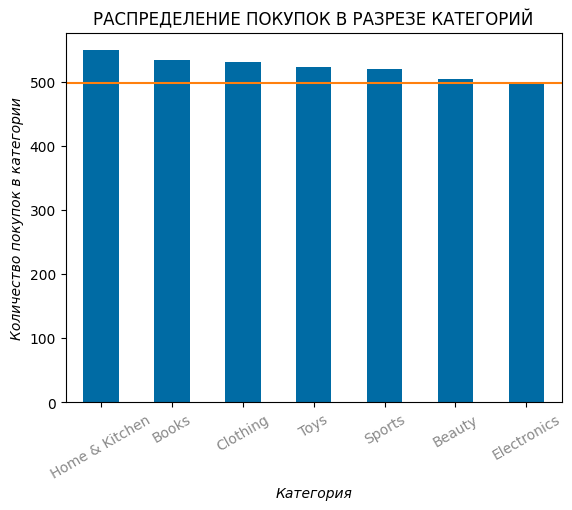

In [145]:
df_ecom["category"].value_counts().plot(kind="bar")

plt.axhline(df_ecom["category"].value_counts().min(), color="C1")
plt.title(
    "Распределение покупок в разрезе категорий".upper(),
    fontdict={"fontsize": 12, "color": "black"},
)
plt.xlabel("Категория", fontstyle='italic')
plt.ylabel("Количество покупок в категории", fontstyle='italic')
plt.xticks(rotation = 30, color = 'C6')
plt.show()

Мы видим, что в целом покупки имеют одинаковое распределение. \
Построим теперь покупки по категориям в динамике

In [181]:
all_category = df_ecom.category.unique()
count_category = len(all_category)

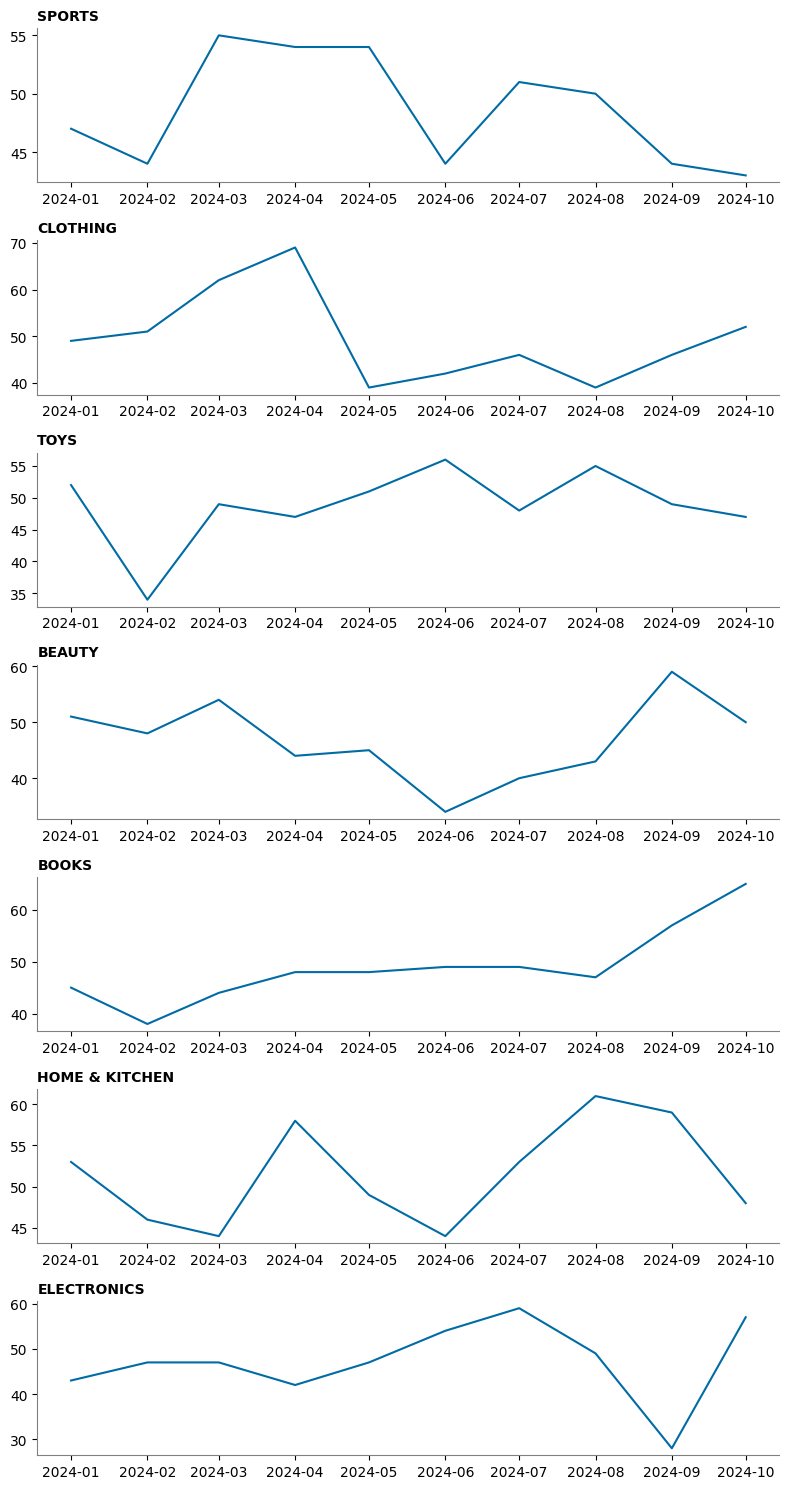

In [229]:
plt.figure(figsize=(8, 15))
for n, category in enumerate(all_category, start=1):
    plt.subplot(count_category, 1, n)
    plt.title(category.upper(), loc="left", fontweight="bold", fontsize=10)

    sns.lineplot(
        df_ecom.groupby(
            by=["category", df_ecom["purchase_date"].dt.to_period("M").dt.start_time]
        )["user_id"]
        .count()
        .reset_index()
        .rename(columns={"user_id": "sales"})
        .query("category == @category and purchase_date < '2024-11-01'"),
        x="purchase_date",
        y="sales",
    )

    plt.xlabel("")
    plt.ylabel("")

    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines[:].set_color("grey")

plt.tight_layout()

Для построения графиков по месяцам был исключён ноябрь, так как этот месяц является неполным

<div class="alert alert-success">
    <strong>Итого</strong>: 

- Исходя из графиков более менее стабильный спрос у электроники и в игрушках
- В книгах идёт также тренд на повышение
- В остальных категориях скорее всего большую роль играют сезонные факторы
</div>